# Noise Reduction

<div class="alert alert-info">

This tutorial is available as an IPython notebook at [malaya-speech/example/noise-reduction](https://github.com/huseinzol05/malaya-speech/tree/master/example/noise-reduction).
    
</div>

<div class="alert alert-warning">

This is an application of malaya-speech Pipeline, read more about malaya-speech Pipeline at [malaya-speech/example/pipeline](https://github.com/huseinzol05/malaya-speech/tree/master/example/pipeline).
    
</div>

Purpose of this module to reduce background musics, noises and etc.

In [1]:
import malaya_speech
import numpy as np
from malaya_speech import Pipeline

In [2]:
y, sr = malaya_speech.load('speech/podcast/SKOLAR.wav', sr = 44100)
len(y), sr, len(y) / sr

(2628043, 44100, 59.59281179138322)

So total length is 60 seconds.

In [3]:
import IPython.display as ipd
ipd.Audio(y[:10 * sr], rate = sr)

This audio extracted from https://www.youtube.com/watch?v=blaIfSWf38Q&t=25s&ab_channel=SkolarMalaysia

As you can hear, the audio got introduction music overlapped with speakers. So we want to reduce that introduction music and possibly split the audio into voice and background noise.

### List available deep model

In [4]:
malaya_speech.noise_reduction.available_model()

Size (MB)  SUM MAE  MAE_SPEAKER  MAE_NOISE
unet                78.9   0.0003          0.0        0.0
resnet34-unet       97.8   0.0003          0.0        0.0

### Load deep model

In [5]:
model = malaya_speech.noise_reduction.deep_model(model = 'unet')

### Important factor

1. Noise Reduction model trained on 44k sample rate, so make sure load the audio with 44k sample rate.

```python
malaya_speech.load(audio_file, sr = 44100)
librosa.load(audio_file, sr = 44100)
```

2. You can feed dynamic length of audio, no need to cap, the model do padding by itself. But again, the longer the audio, the longer time required to calculate, unless you have GPU to speed up.
3. STFT and Inverse STFT can be done on GPU level, so the model is really fast on GPU.

In [6]:
%%time

output = model(y)

CPU times: user 8.24 s, sys: 1.83 s, total: 10.1 s
Wall time: 3.08 s


In [7]:
output

{'voice': array([ 1.1494245e-05,  1.1490130e-05,  1.3894378e-05, ...,
        -3.0526999e-02, -2.9316220e-02, -2.1699090e-02], dtype=float32),
 'noise': array([-1.0790808e-05, -1.4368378e-05, -1.4604203e-05, ...,
        -9.1139920e-04, -3.1386856e-03, -1.4713373e-03], dtype=float32)}

In [8]:
ipd.Audio(output['voice'][:10 * sr], rate = sr)

In [9]:
ipd.Audio(output['noise'][:10 * sr], rate = sr)

Nicely done!

### Use Pipeline

Incase your audio is too long and you do not want to burden your machine. So, you can use malaya-speech Pipeline to split the audio splitted to 15 seconds and predict one-by-one and combine after that.

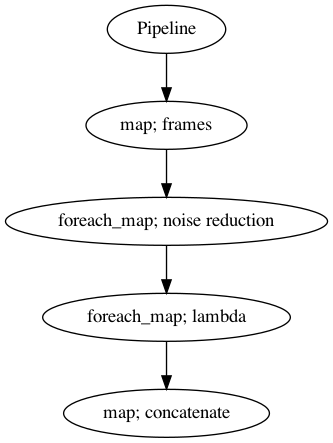

In [10]:
p = Pipeline()
pipeline = (
    p.map(malaya_speech.generator.frames, frame_duration_ms = 15000, sample_rate = sr)
    .foreach_map(model)
    .foreach_map(lambda x: x['voice'])
    .map(np.concatenate)
)
p.visualize()

In [11]:
%%time

results = p.emit(y)

CPU times: user 9.33 s, sys: 2.1 s, total: 11.4 s
Wall time: 2.51 s


In [13]:
results.keys()

dict_keys(['frames', 'noise-reduction', '<lambda>', 'concatenate'])

In [15]:
ipd.Audio(results['concatenate'][:10 * sr], rate = sr)